# Cadenas de markov tarea 0

Tuli Peña Melo, Juan Bernardo Soto Pescador, Francisco Jose Gutierrez Peña


En este notebook usamos 2.5 maneras distintas (uno podrñia argumentar que son tres maneras distintas, pero dos son extremadamente similares) de computacionalmente encontrar una distribución estacionaria de la cadena de markov dada en clase. La primera idea surge de este paper https://iate.oac.uncor.edu/~mario/materia/nr/numrec/f11-3.pdf. Basicamente si tenemos una matriz tridiagonal simetrica, tenemos un algoritmo especial llamado QL, donde podemos encontrar los autovalores muy rapidamente, este algoritmo usa rotaciones y corrimientos para encontrar los autovectores con una complejidad de O(n^2). Sin embargo si bien nuestra matriz es tridiagonal NO ES SIMETRICA, pero es reversible (ya que la cadena de markov es reversible), entonces existe una matriz simetrica tridiagonal S, tal que S=DPD^-1. Para esto usamos la librería de scipy que ya tiene un modulo integrado sobre tipo de matrices. Hay dos versiones del algoritmo con matrices,una carga toda la matriz n x n, mientras que la otra usa la estructura de la matriz calcular la matriz S. Los dos algoritmos tienen una velocidad casi identica, pero el segundo algoritmo procesar cadenas de markov de hasta 10^5 estados, mientras que el primero empieza a tener errores de memoria con este tipo de valores.


El otro algoritmo fundamentalmente distinto es el algoritmo de tiempos medios de regreso. En está implementación hay n-1 ecuaciones lineales que resolver lo cual tiene una complejidad de O(n^3), y hacemos esto por cada estado es decir la complejidad queda de O(n^4).Por la teoría la diferencia es clara y en lo practico tambien, ya que el algoritmo tiene problemas con valores de n semejantes a 10^4



[Denso] n=  100 -> 0.0000 seg
[Denso] n= 6080 -> 1.8157 seg
[Denso] n=12060 -> 10.4593 seg
[Denso] n=18040 -> 32.6257 seg
[Denso] n=24020 -> 72.7307 seg
[Denso] n=30000 -> 135.7608 seg
[Tridiag] n=  100 -> 0.0010 seg
[Tridiag] n= 6080 -> 1.7846 seg
[Tridiag] n=12060 -> 10.4698 seg
[Tridiag] n=18040 -> 32.6651 seg
[Tridiag] n=24020 -> 72.6241 seg
[Tridiag] n=30000 -> 135.4469 seg
[ReturnTimes] n=  100 -> 0.4930 seg
[ReturnTimes] n=  280 -> 5.3059 seg
[ReturnTimes] n=  460 -> 14.0806 seg
[ReturnTimes] n=  640 -> 27.0897 seg
[ReturnTimes] n=  820 -> 43.7050 seg
[ReturnTimes] n= 1000 -> 61.9128 seg


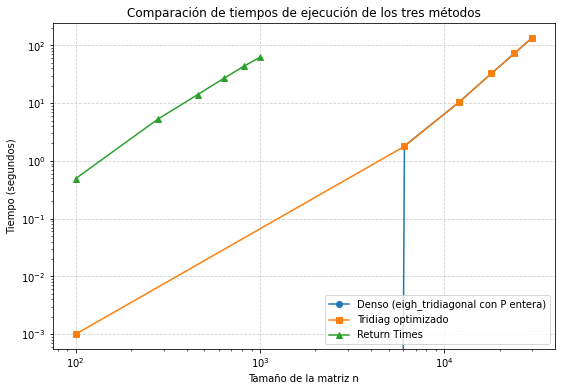

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal

# --- Algoritmo 1: versión densa ---
def build_P(n, p):
    P = np.zeros((n, n), dtype=float)
    for i in range(n-1):
        P[i, i+1] = p
    for i in range(1, n):
        P[i, i-1] = 1.0 - p
    P[0,0] = 1.0 - p
    P[-1,-1] = p
    return P

def stationary_via_tqli_dense(P, p=None):
    n = P.shape[0]
    if p is None:
        p = float(P[0,1])
    q = 1.0 - p
    r = p / q
    indices = np.arange(n, dtype=float)
    pi_unnorm = r ** indices
    D = np.sqrt(pi_unnorm)

    d = np.array([P[i,i] for i in range(n)], dtype=float)
    e = np.array([np.sqrt(P[i,i+1]*P[i+1,i]) for i in range(n-1)], dtype=float)

    evals, evecs = eigh_tridiagonal(d, e)
    idx = np.argmin(np.abs(evals - 1.0))
    v = evecs[:, idx]

    pi_col = D * v
    if pi_col.sum() < 0:
        pi_col = -pi_col
    pi = np.where(pi_col < 0, 0.0, pi_col)
    return pi / pi.sum()

# --- Algoritmo 2: tridiagonal optimizado ---
def stationary_via_tqli_tridiag(n, p):
    q = 1.0 - p
    r = p / q
    indices = np.arange(n, dtype=float)
    pi_unnorm = r ** indices
    D = np.sqrt(pi_unnorm)

    d = np.zeros(n)
    d[0] = 1.0 - p
    d[-1] = p
    e = np.sqrt(p*q) * np.ones(n-1)

    evals, evecs = eigh_tridiagonal(d, e)
    idx = np.argmin(np.abs(evals - 1.0))
    v = evecs[:, idx]
    pi_col = D * v
    if pi_col.sum() < 0:
        pi_col = -pi_col
    pi = np.where(pi_col < 0, 0.0, pi_col)
    return pi / pi.sum()

# --- Algoritmo 3: tiempos medios de regreso ---
def stationary_via_return_times(P, tol=1e-12, use_lstsq_on_singular=True):
    P = np.array(P, dtype=float)
    n = P.shape[0]
    r = np.empty(n, dtype=float)
    for i in range(n):
        idx = [j for j in range(n) if j != i]
        if len(idx) == 0:
            r[i] = 1.0
            continue
        A = np.eye(n-1) - P[np.ix_(idx, idx)]
        b = np.ones(n-1)
        try:
            t_sub = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            if not use_lstsq_on_singular:
                raise
            t_sub, *_ = np.linalg.lstsq(A, b, rcond=None)
        r[i] = 1.0 + np.dot(P[i, idx], t_sub)
    inv_r = 1.0 / r
    pi = inv_r / np.sum(inv_r)
    return pi, r

# --- Benchmark con gráfico ---
def benchmark_three_methods(max_n_matrix=800, max_n_recursive=5000, steps=6, p=0.3):
    """
    Compara los tres métodos (denso, tridiag, return_times) en función de n.
    - max_n_dense: límite superior para el método denso (memoria restringida).
    - max_n_tridiag: límite superior para tridiag y return_times.
    - steps: número de puntos de prueba.
    """
    ns_matrix = np.linspace(100, max_n_matrix, steps, dtype=int)
    ns_recursive = np.linspace(100, max_n_recursive, steps, dtype=int)

    tiempos_dense, tiempos_tridiag, tiempos_return = [], [], []

    # --- Denso ---
    for n in ns_matrix:
        P = build_P(n, p)
        start = time.time()
        stationary_via_tqli_dense(P, p)
        end = time.time()
        tiempos_dense.append(end - start)
        print(f"[Denso] n={n:5d} -> {end-start:.4f} seg")

    # --- Tridiag ---
    for n in ns_matrix:
        start = time.time()
        stationary_via_tqli_tridiag(n, p)
        end = time.time()
        tiempos_tridiag.append(end - start)
        print(f"[Tridiag] n={n:5d} -> {end-start:.4f} seg")

    # --- Return times ---
    for n in ns_recursive:  # mismo rango que tridiag
        P = build_P(n, p)
        start = time.time()
        stationary_via_return_times(P)
        end = time.time()
        tiempos_return.append(end - start)
        print(f"[ReturnTimes] n={n:5d} -> {end-start:.4f} seg")

    # --- Gráfico comparativo ---
    plt.figure(figsize=(9,6))
    plt.plot(ns_matrix, tiempos_dense, "o-", label="Denso (eigh_tridiagonal con P entera)")
    plt.plot(ns_matrix, tiempos_tridiag, "s-", label="Tridiag optimizado")
    plt.plot(ns_recursive, tiempos_return, "^-", label="Return Times")
    plt.title("Comparación de tiempos de ejecución de los tres métodos")
    plt.xlabel("Tamaño de la matriz n")
    plt.ylabel("Tiempo (segundos)")
    
    plt.xscale("log")   # eje X logarítmico
    plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    
    benchmark_three_methods(max_n_matrix=30000, max_n_recursive=1000, steps=6, p=0.3)

